# Exploratory Data Analysis

## Initial Settings

### Roots and Paths

In [1]:
import sys
from pathlib import Path

# Ruta a la raíz del proyecto
project_root = Path().resolve().parent
sys.path.append(str(project_root))

### Libraries and Dependencies

In [2]:
import src.utils as ut
import src.config as cf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

pd.options.display.max_columns = None
sns.set_style('dark')
sns.set_palette('dark')

project path: C:\Users\Usuario\OneDrive\Documentos\Proyectos Personales\Data Science\Public Portfolio Data Science\241117 Telco Customer Churn
raw data path: C:\Users\Usuario\OneDrive\Documentos\Proyectos Personales\Data Science\Public Portfolio Data Science\241117 Telco Customer Churn\data\raw_data.csv
clean data path: C:\Users\Usuario\OneDrive\Documentos\Proyectos Personales\Data Science\Public Portfolio Data Science\241117 Telco Customer Churn\data\clean_data.csv
model path C:\Users\Usuario\OneDrive\Documentos\Proyectos Personales\Data Science\Public Portfolio Data Science\241117 Telco Customer Churn\models\model.pkl
results path C:\Users\Usuario\OneDrive\Documentos\Proyectos Personales\Data Science\Public Portfolio Data Science\241117 Telco Customer Churn\results


### Data Loading

In [3]:
df = ut.load_data(cf.raw_data_path)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Preliminary EDA

### Basic Information

In [4]:
# dataset size
print(f'Dimensions: {df.shape}')

# summary table
ut.summary_info(df)

Dimensions: (7043, 21)


Column,Non-Null Count,Missing %,Unique Values,Data Type
customerID,"7,043",0.000000,"7,043",object
DeviceProtection,"7,043",0.000000,3,object
TotalCharges,"7,043",0.000000,"6,531",object
MonthlyCharges,"7,043",0.000000,"1,585",float64
PaymentMethod,"7,043",0.000000,4,object
PaperlessBilling,"7,043",0.000000,2,object
Contract,"7,043",0.000000,3,object
StreamingMovies,"7,043",0.000000,3,object
StreamingTV,"7,043",0.000000,3,object
TechSupport,"7,043",0.000000,3,object


### Missing Values

In [5]:
ut.missing_values_by_pivot(df, 'StreamingTV', return_type='percentage', percentage_base= 'total')

StreamingTV,No,No internet service,Yes
customerID,0.0,0.0,0.0
gender,0.0,0.0,0.0
SeniorCitizen,0.0,0.0,0.0
Partner,0.0,0.0,0.0
Dependents,0.0,0.0,0.0
tenure,0.0,0.0,0.0
PhoneService,0.0,0.0,0.0
MultipleLines,0.0,0.0,0.0
InternetService,0.0,0.0,0.0
OnlineSecurity,0.0,0.0,0.0


## Numerical Feature Analysis

### Selection of numerical features

In [6]:
numerical_cols = df.select_dtypes(include = ['int64', 'float64']).columns

### Statistical Summary

In [7]:
# statistical summary
df.describe().applymap(lambda x: ut.format_cell(x)).style.applymap(ut.center_align)

,SeniorCitizen,tenure,MonthlyCharges
count,"7,043","7,043","7,043"
mean,0.16,32.37,64.76
std,0.37,24.56,30.09
min,0,0,18.25
25%,0,9,35.50
50%,0,29,70.35
75%,0,55,89.85
max,1,72,118.75


### Histograms

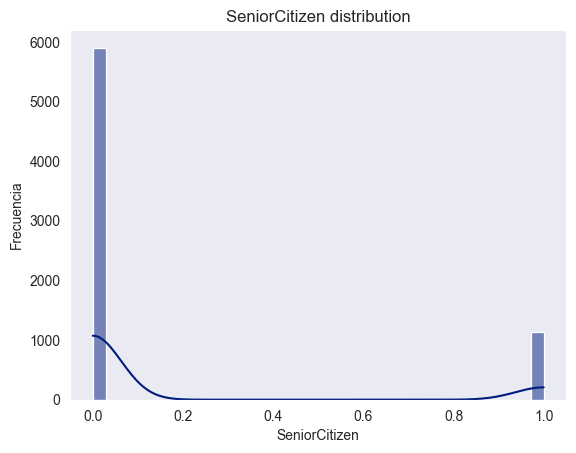

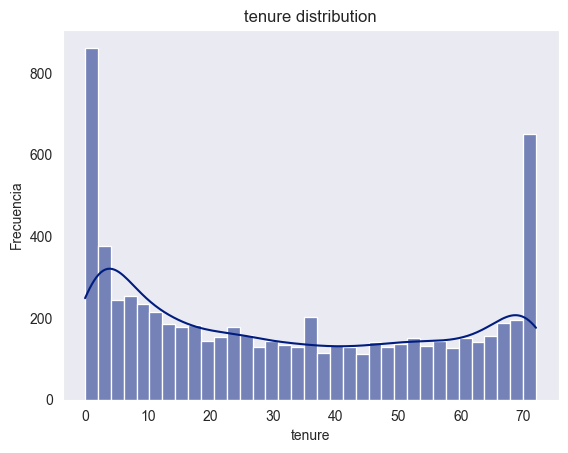

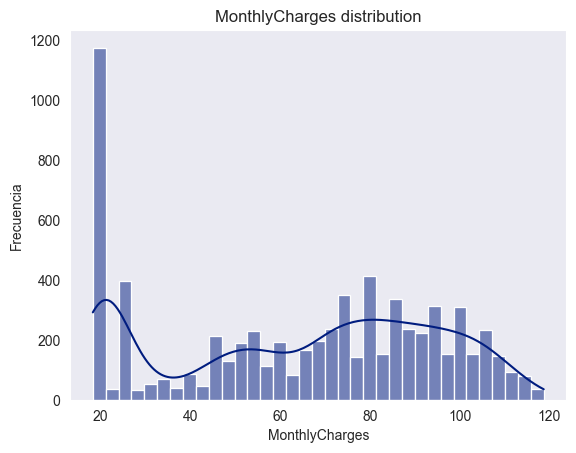

In [8]:
# create histogram and density curves

for col in numerical_cols:
    sns.histplot(df[col], kde = True, bins = 35)
    plt.title(f'{col} distribution')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.show()

### Box Plots

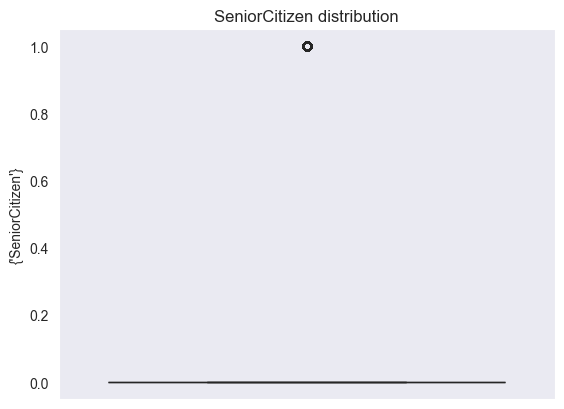

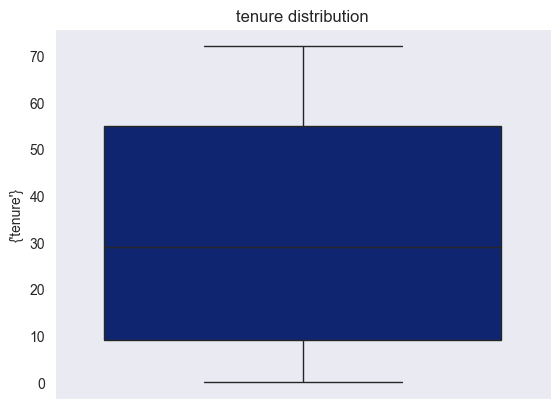

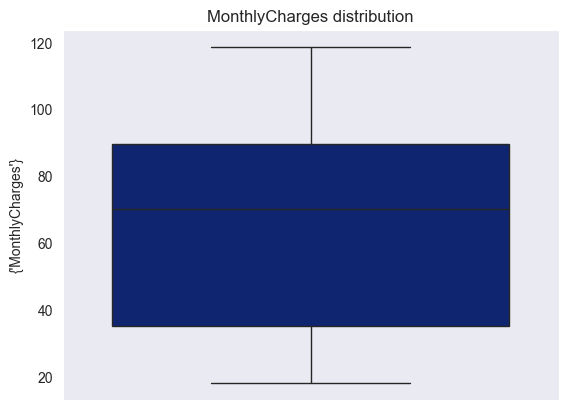

In [9]:
for col in numerical_cols:
    sns.boxplot(y = df[col])
    plt.title(f'{col} distribution')
    plt.ylabel({col})
    plt.show()

### Pair Plots

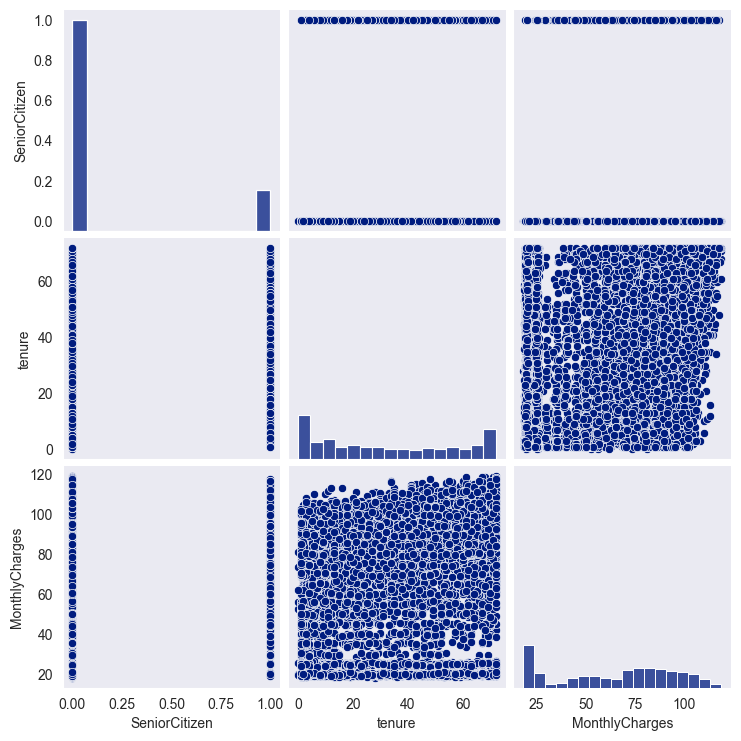

In [10]:
sns.pairplot(df[numerical_cols])
plt.show()

### Heatmap

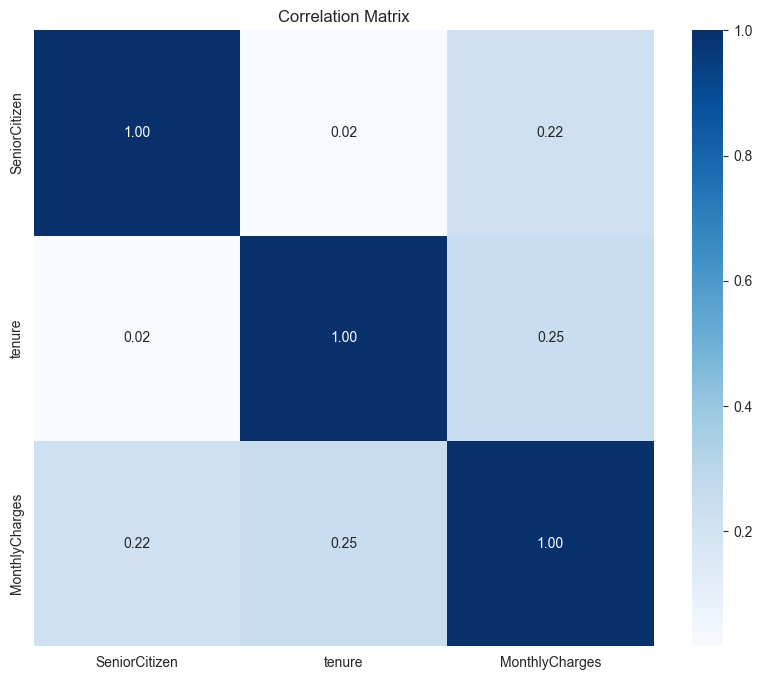

In [11]:
correlation_matrix = df[numerical_cols].corr()
plt.figure(figsize = (10, 8))
sns.heatmap(correlation_matrix, annot = True, fmt = ".2f", cmap = 'Blues', cbar = True)
plt.title('Correlation Matrix')
plt.show()

## Categorical Features Distributions

### Selection of Categorical Features

In [12]:
cat_columns = list(set(df.columns) - set(numerical_cols))
cat_columns.remove('TotalCharges')
cat_columns.remove('customerID')

In [13]:
cat_columns

['PaperlessBilling',
 'StreamingMovies',
 'OnlineSecurity',
 'TechSupport',
 'DeviceProtection',
 'gender',
 'PaymentMethod',
 'OnlineBackup',
 'InternetService',
 'Contract',
 'Partner',
 'MultipleLines',
 'Churn',
 'PhoneService',
 'StreamingTV',
 'Dependents']

### Uniqueness

In [14]:
ut.uniqueness_categorical_columns(df, max_categories = 10)

--- Column: customerID ---
Unique values: 7043


Category,Percentage
7590-VHVEG,0.01%
3791-LGQCY,0.01%
6008-NAIXK,0.01%
5956-YHHRX,0.01%
5365-LLFYV,0.01%
5855-EIBDE,0.01%
8166-ZZTFS,0.01%
0129-KPTWJ,0.01%
9128-CPXKI,0.01%
9509-MPYOD,0.01%


... showing the top 10 most common values


--- Column: gender ---
Unique values: 2


Category,Percentage
Male,50.48%
Female,49.52%




--- Column: Partner ---
Unique values: 2


Category,Percentage
No,51.70%
Yes,48.30%




--- Column: Dependents ---
Unique values: 2


Category,Percentage
No,70.04%
Yes,29.96%




--- Column: PhoneService ---
Unique values: 2


Category,Percentage
Yes,90.32%
No,9.68%




--- Column: MultipleLines ---
Unique values: 3


Category,Percentage
No,48.13%
Yes,42.18%
No phone service,9.68%




--- Column: InternetService ---
Unique values: 3


Category,Percentage
Fiber optic,43.96%
DSL,34.37%
No,21.67%




--- Column: OnlineSecurity ---
Unique values: 3


Category,Percentage
No,49.67%
Yes,28.67%
No internet service,21.67%




--- Column: OnlineBackup ---
Unique values: 3


Category,Percentage
No,43.84%
Yes,34.49%
No internet service,21.67%




--- Column: DeviceProtection ---
Unique values: 3


Category,Percentage
No,43.94%
Yes,34.39%
No internet service,21.67%




--- Column: TechSupport ---
Unique values: 3


Category,Percentage
No,49.31%
Yes,29.02%
No internet service,21.67%




--- Column: StreamingTV ---
Unique values: 3


Category,Percentage
No,39.90%
Yes,38.44%
No internet service,21.67%




--- Column: StreamingMovies ---
Unique values: 3


Category,Percentage
No,39.54%
Yes,38.79%
No internet service,21.67%




--- Column: Contract ---
Unique values: 3


Category,Percentage
Month-to-month,55.02%
Two year,24.07%
One year,20.91%




--- Column: PaperlessBilling ---
Unique values: 2


Category,Percentage
Yes,59.22%
No,40.78%




--- Column: PaymentMethod ---
Unique values: 4


Category,Percentage
Electronic check,33.58%
Mailed check,22.89%
Bank transfer (automatic),21.92%
Credit card (automatic),21.61%




--- Column: TotalCharges ---
Unique values: 6531


Category,Percentage
,0.16%
20.2,0.16%
19.75,0.13%
20.05,0.11%
19.9,0.11%
19.65,0.11%
45.3,0.10%
19.55,0.10%
20.15,0.09%
20.25,0.09%


... showing the top 10 most common values


--- Column: Churn ---
Unique values: 2


Category,Percentage
No,73.46%
Yes,26.54%


### Count Plot

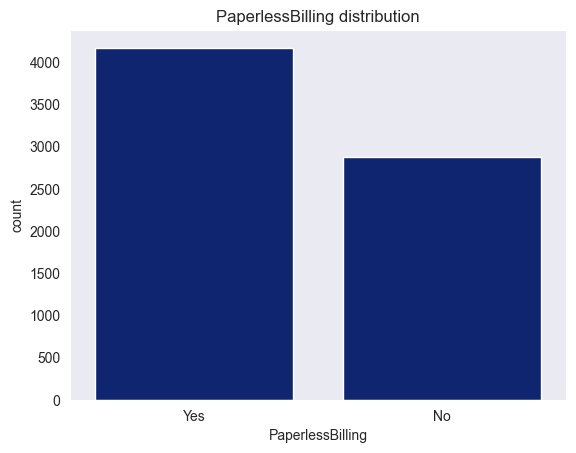

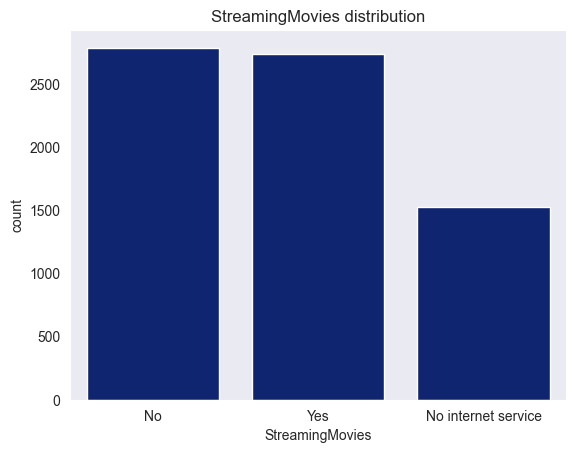

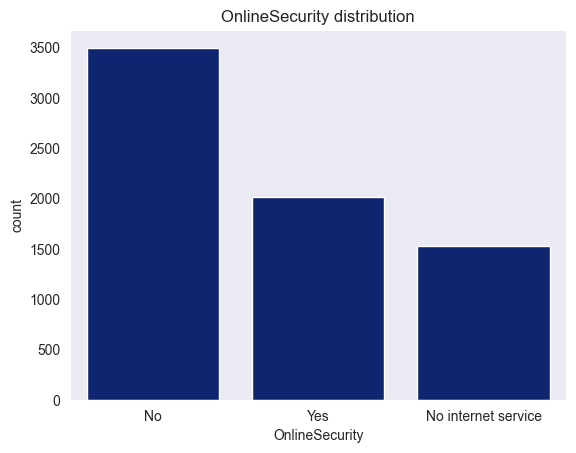

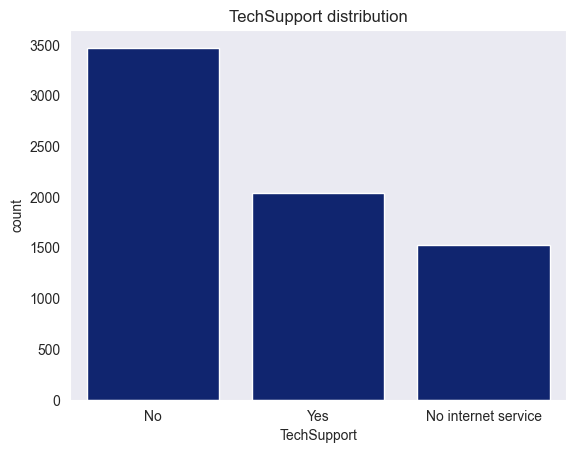

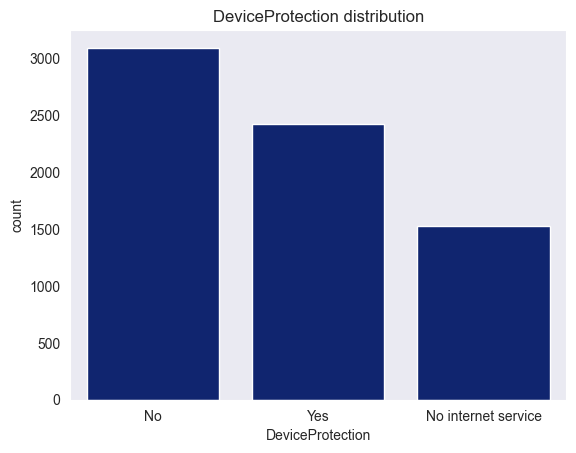

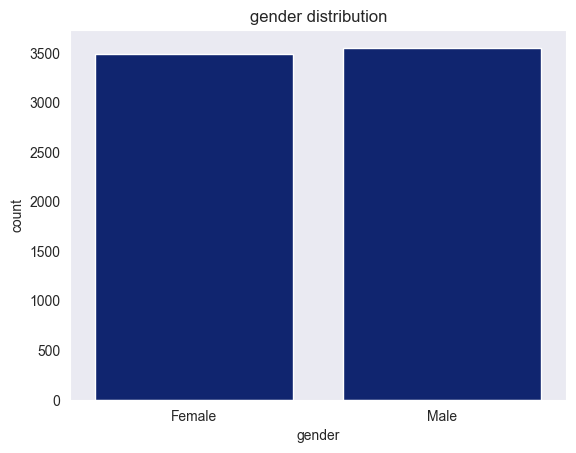

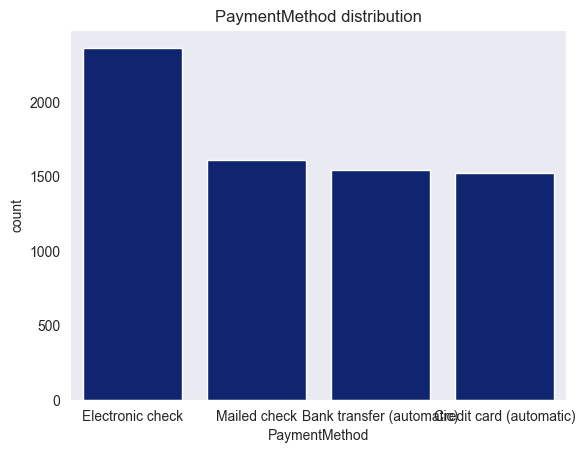

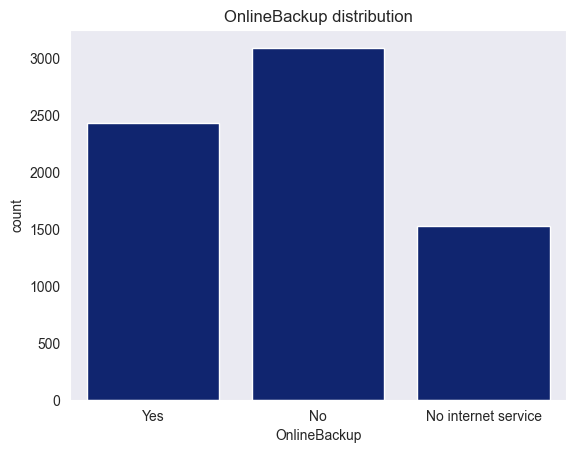

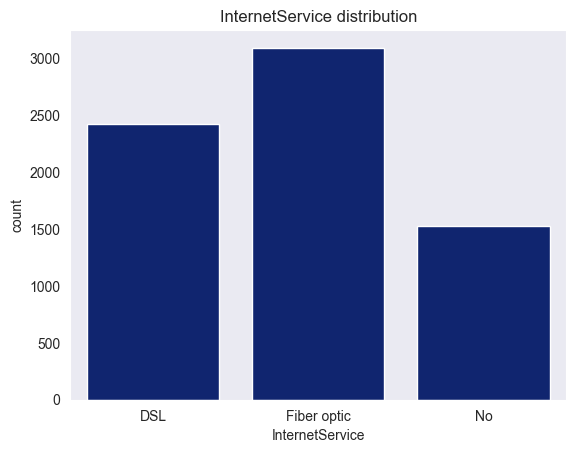

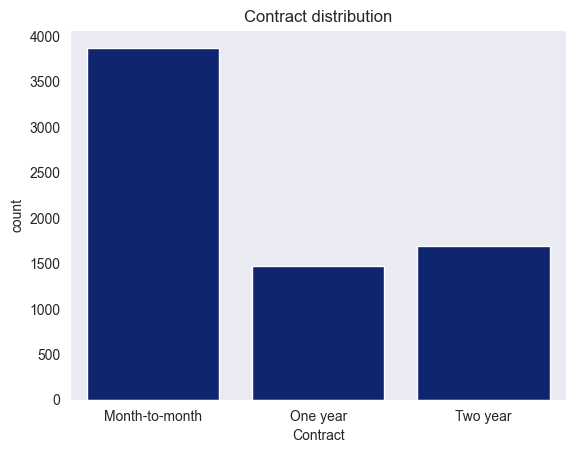

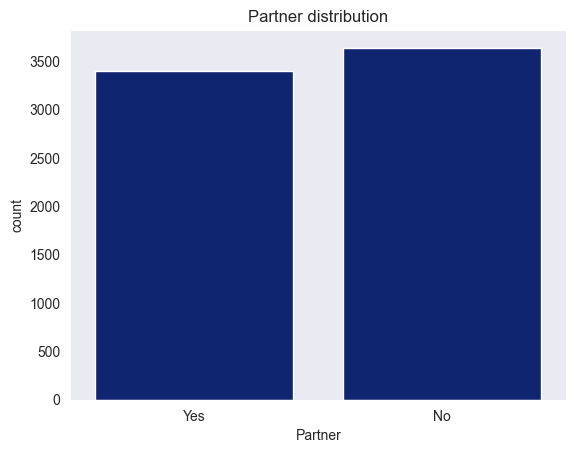

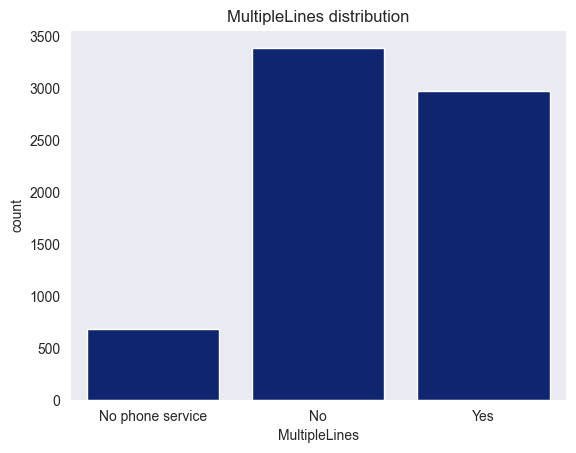

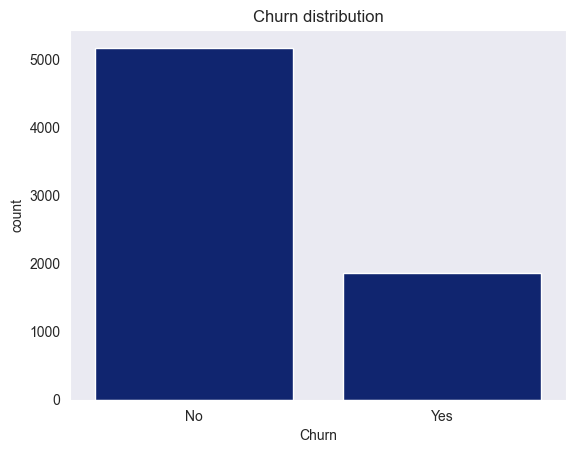

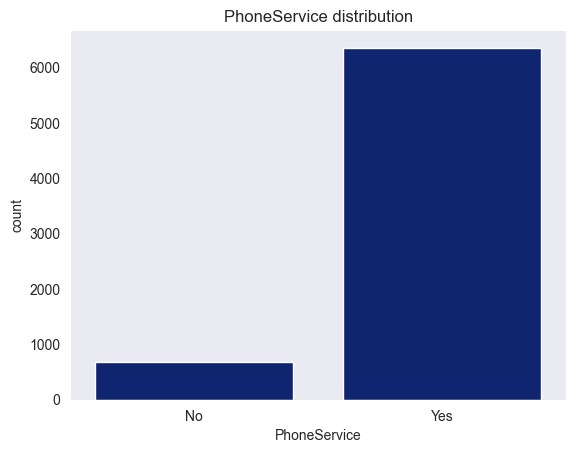

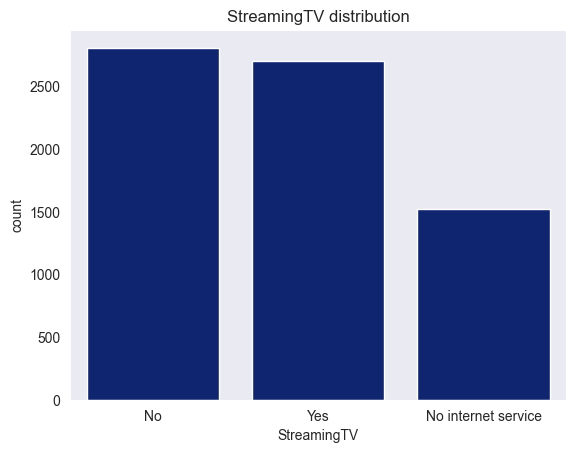

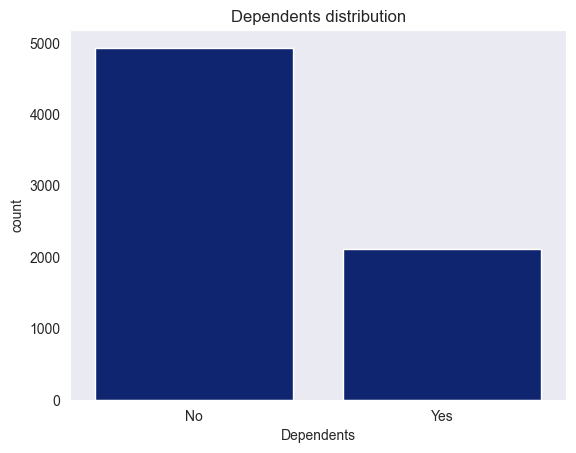

In [15]:
for col in cat_columns:
    sns.countplot(x = col, data = df)
    plt.title(f'{col} distribution')
    plt.show()

### Crosstabs

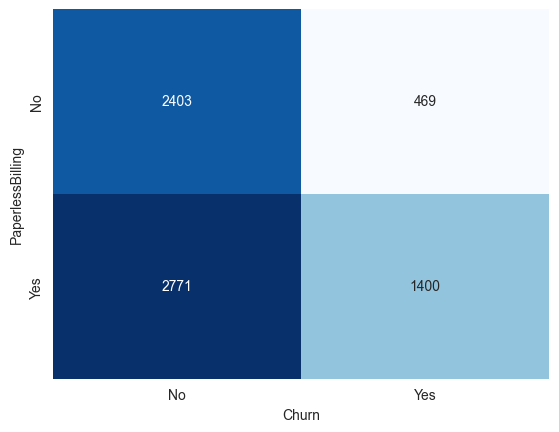

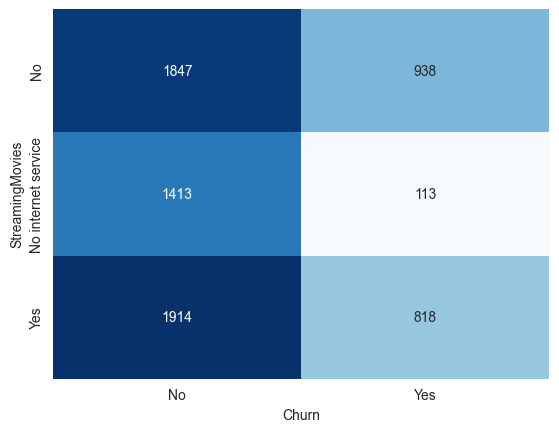

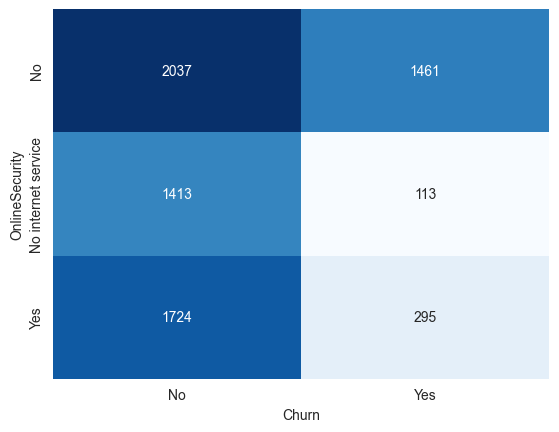

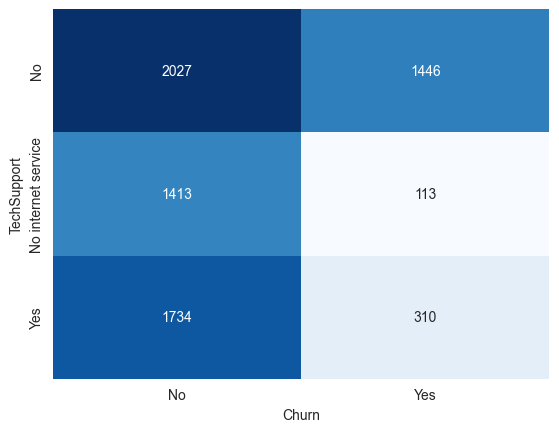

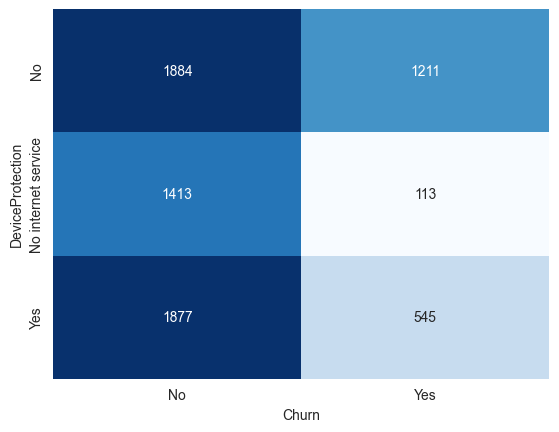

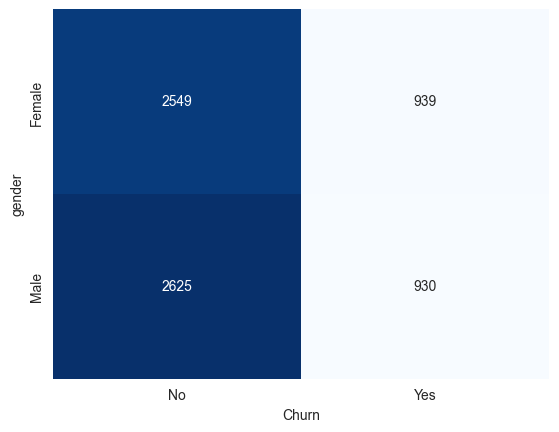

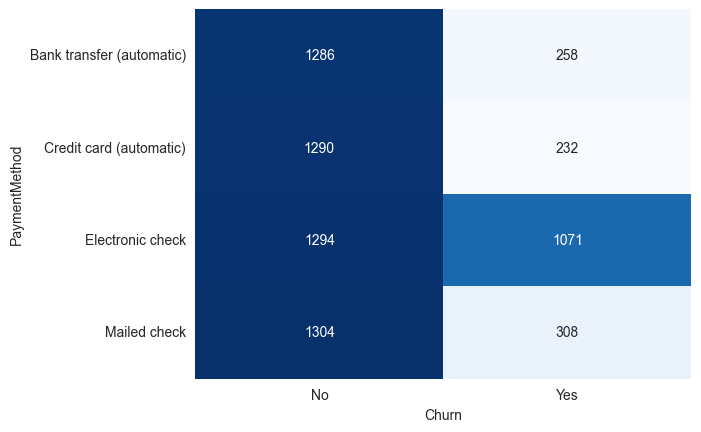

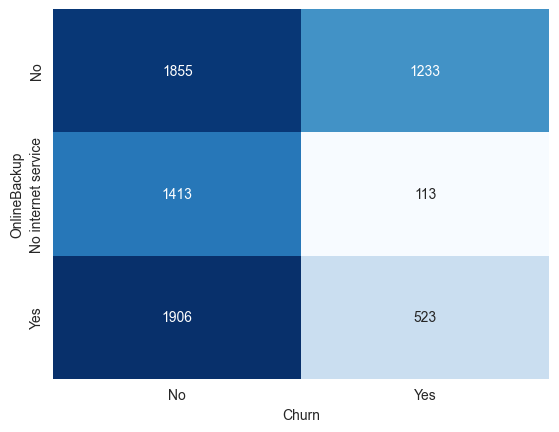

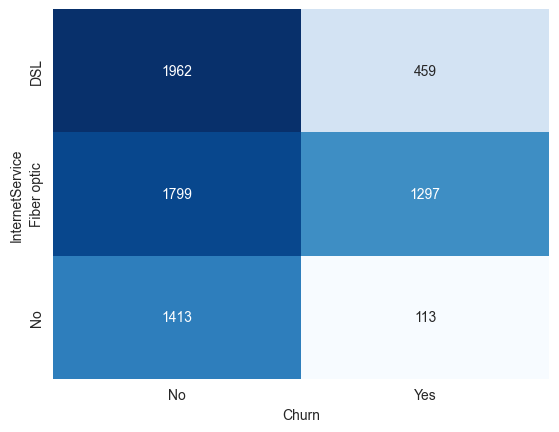

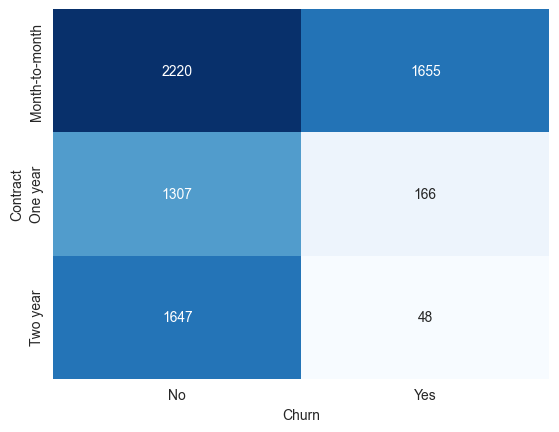

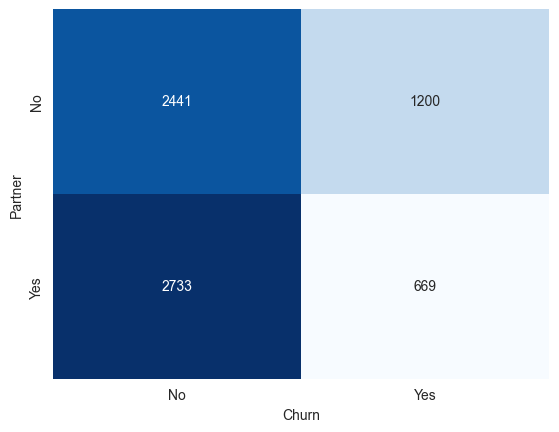

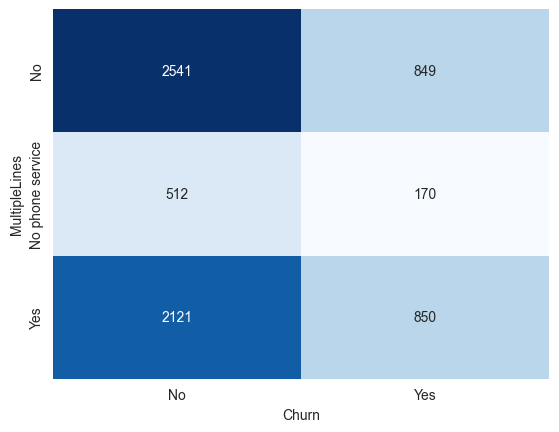

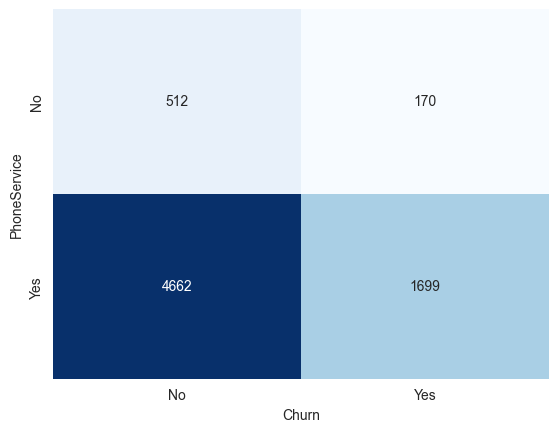

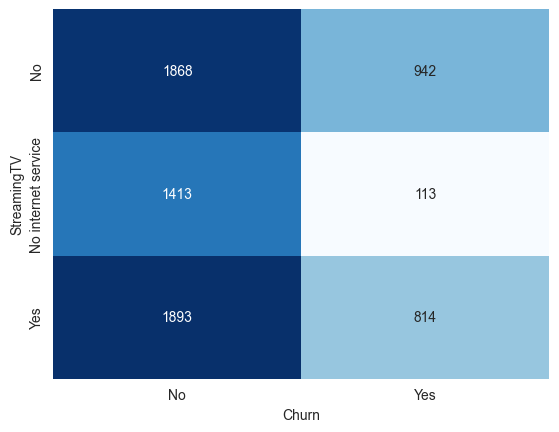

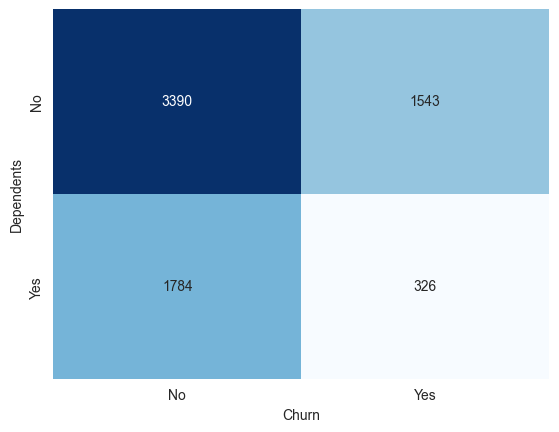

In [25]:
#cross_tabs_cols = cat_columns.remove('Churn')
for col in cat_columns:
    cross = pd.crosstab(df[col], df['Churn'])

    sns.heatmap(cross, annot = True, fmt = 'd', cmap = 'Blues', cbar= False)
    plt.show()

<Axes: xlabel='Churn', ylabel='Contract-PaymentMethod'>

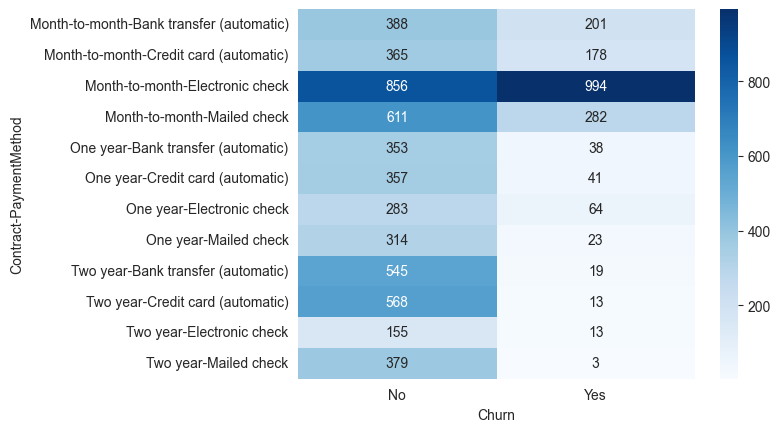

In [18]:
contract_churn = pd.crosstab([df['Contract'], df["PaymentMethod"]], df['Churn'])

sns.heatmap(contract_churn, annot = True, fmt = 'd', cmap = 'Blues')

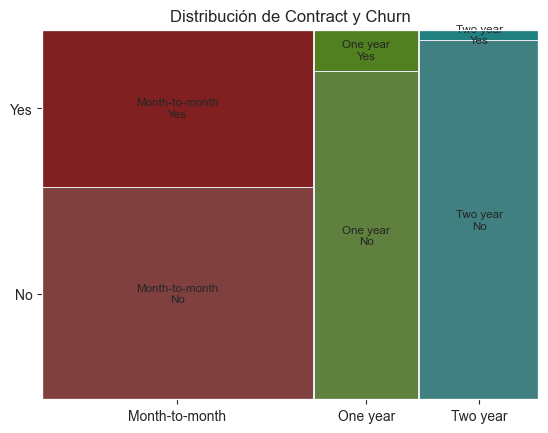

In [ ]:
from statsmodels.graphics.mosaicplot import mosaic

# Mosaic plot entre Contract y Churn
mosaic(df, ['Contract', 'Churn'], title="Contract vs Churn distribution")
plt.show()